# Model validity tutorial


### What's model validity and why does it matter?

In this context, under model validity we understand identifying the part of the input space where AlphaPEM produces polarization curves that are *physically meaningful*.

AlphaPEM takes 19 input parameters (operating conditions and undetermined physical parameters) and simulates a polarization curve.
If we simply vary each parameter within the broad ranges provided by the model's author and partners, we quickly see a problem:

* Many configurations produce invalid outputs (negative or unrealistic voltages).
* Each run takes time (\~1.5 minutes), so exploring invalid points is computationally wasteful.

Our goal in this phase is to:

1. Label each configuration as valid or invalid based on the shape and properties of its simulated polarization curve.
2. Prepare the dataset so that later we can find a compact, interpretable region of validity.
3. Save the labeled data so that a separate R script can learn a hyperbox of valid configurations later.
4. Apply the IRD method to find such hyperbox and save it as a yaml.


In [1]:
from pathlib import Path
import pandas as pd
import yaml
import sys
import subprocess
import datetime
import shutil

# Relative path to repo root 
parent = Path("..")

# Make src importable
if str(parent.resolve()) not in sys.path:
    sys.path.append(str(parent))

from src.sampling.bounds import load_param_config
from src.validity.validity_criteria import validate_polarization_curves
from src.visualization.polarization import plot_polarization_curves

# Define directories
param_config_yaml = str(parent / "configs" / "original_param_config.yaml")
raw_dir           = parent / "data" / "raw"
processed_dir     = parent / "data" / "processed"

## 1) Original parameter ranges

We work with **19 parameters** in total: **7 operating conditions** and **12 undetermined physical parameters**.  
These ranges come from the file `original_param_config.yaml`. Here, the parameter ranges of the 19 parameters are stated, where those of the operating parameters were agreed with project partners and those of the undetermined physical parameters were extracted from the recommendation of AlphaPEM's author Raphaël Gass (see Table 3.1. of the thesis).  

Below we load the file and show the lower and upper bound for each parameter.


In [2]:
spec = load_param_config(param_config_yaml)

i = 1
for name in spec.names:
    p = spec.spec_index[name]
    if p["type"] in ("continuous", "integer"):
        print(f"{i}  {name:15}   | type={p['type']:10} | low={p['low']} | high={p['high']}")
    elif p["type"] == "categorical":
        print(f"{i}   {name:15} | type=categorical | values={p['values']}")
    i = i + 1

1  Tfc               | type=continuous | low=333 | high=363
2  Pa_des            | type=continuous | low=130000.0 | high=300000.0
3  Pc_des            | type=continuous | low=110000.0 | high=300000.0
4  Sa                | type=continuous | low=1.1 | high=3.0
5  Sc                | type=continuous | low=1.1 | high=3.0
6  Phi_a_des         | type=continuous | low=0.1 | high=0.7
7  Phi_c_des         | type=continuous | low=0.1 | high=0.7
8  epsilon_gdl       | type=continuous | low=0.55 | high=0.8
9  tau               | type=continuous | low=1.0 | high=4.0
10  epsilon_mc        | type=continuous | low=0.15 | high=0.4
11  epsilon_c         | type=continuous | low=0.15 | high=0.3
12   e               | type=categorical | values=[3, 4, 5]
13  Re                | type=continuous | low=5e-07 | high=5e-06
14  i0_c_ref          | type=continuous | low=0.001 | high=500.0
15  kappa_co          | type=continuous | low=0.01 | high=40.0
16  kappa_c           | type=continuous | low=0.0 | high=100.0


## 2) Load the raw configurations with polarization curves

For this exercise, we will be using: `../data/raw/configs_for_IRD_until_2025-06-16.csv`.  
This file contains more than 2000 rows, one per configuration, with columns for `Ucell_1...Ucell_N` and `ifc_1...ifc_N` that represent each polarization curve.

In [3]:
file_path = Path(raw_dir, "configs_for_IRD_until_2025-06-16.csv")

if not file_path.exists():
    print("CSV not found")
    print("Please place 'configs_for_IRD_until_2025-06-16.csv' under ../data/raw and re-run this cell.")
else:
    df = pd.read_csv(file_path)
    print(f"Loaded shape: {df.shape}")
    # Peek
    display(df.head(3))

print("Columns present at the df:")
df.columns

Loaded shape: (2370, 85)


,index,config_id,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,...,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31
0,0,43d2daa781d25ab45b1b5def5d319b486d92034e5762f7...,335.0159,215267.894967,195267.894967,1.3,2.784156,0.5,0.607013,0.663508,...,-1.539867,-1.637326,-1.733689,-1.828860,-1.922645,-2.015282,-2.107036,-2.198002,-2.288234,-2.377778
1,1,4480b2b2ee7269935ed29e466e1f7ac011a14814d4cfa6...,335.0159,215267.894967,195267.894967,1.3,2.784156,0.5,0.607013,0.663508,...,0.098713,0.059788,0.021237,-0.016953,-0.054699,-0.092047,-0.129114,-0.165950,-0.202581,-0.239030
2,2,9a78a65ec3a41334db55dd373f5fc39863759de5f937f3...,335.0159,215267.894967,195267.894967,1.3,2.784156,0.5,0.607013,0.663508,...,0.107368,0.068453,0.029930,-0.008172,-0.045792,-0.083021,-0.119959,-0.156646,-0.193106,-0.229362


Columns present at the df:


Index(['index', 'config_id', 'Tfc', 'Pa_des', 'Pc_des', 'Sa', 'Sc',
       'Phi_a_des', 'Phi_c_des', 'epsilon_gdl', 'tau', 'epsilon_mc',
       'epsilon_c', 'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c', 'a_slim',
       'b_slim', 'a_switch', 'ifc', 'Ucell', 'ifc_1', 'ifc_2', 'ifc_3',
       'ifc_4', 'ifc_5', 'ifc_6', 'ifc_7', 'ifc_8', 'ifc_9', 'ifc_10',
       'ifc_11', 'ifc_12', 'ifc_13', 'ifc_14', 'ifc_15', 'ifc_16', 'ifc_17',
       'ifc_18', 'ifc_19', 'ifc_20', 'ifc_21', 'ifc_22', 'ifc_23', 'ifc_24',
       'ifc_25', 'ifc_26', 'ifc_27', 'ifc_28', 'ifc_29', 'ifc_30', 'ifc_31',
       'Ucell_1', 'Ucell_2', 'Ucell_3', 'Ucell_4', 'Ucell_5', 'Ucell_6',
       'Ucell_7', 'Ucell_8', 'Ucell_9', 'Ucell_10', 'Ucell_11', 'Ucell_12',
       'Ucell_13', 'Ucell_14', 'Ucell_15', 'Ucell_16', 'Ucell_17', 'Ucell_18',
       'Ucell_19', 'Ucell_20', 'Ucell_21', 'Ucell_22', 'Ucell_23', 'Ucell_24',
       'Ucell_25', 'Ucell_26', 'Ucell_27', 'Ucell_28', 'Ucell_29', 'Ucell_30',
       'Ucell_31'],
      d

## 3) Classify each curve as valid or invalid

We use the `validate_polarization_curves()` function.  
The function checks a few intuitive properties of a "good" polarization curve, like a sensible starting voltage, (approximate) monotonic drop along current density and positive voltage for small current density. You can tweak thresholds if needed. By placing your mouse on the name of the function, its documentation will be displayed.

The result is a new column called `classification` with values `valid` or `invalid`.


In [4]:
# Define which criteria to apply
criteria = {
    "start_in_range": True,
    "approx_monotonic": True
}

# Apply the validation
df_validity = validate_polarization_curves(
    df = df,
    apply_criteria=criteria,        
    voltage_range=(0, 1.23),            # Sensible range for the starting voltage
    approx_monotonic_threshold=0.005,   # Tolerance (small bumps <5mV are allowed)
    filter_invalid = False,             # When true, it filters out the invalid configuration
    keep_temp_cols = True               # So we can see which condition each config violates
)

print(len(df_validity))
display(df_validity.head())

2370


,index,config_id,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,...,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31,start_in_range,approx_monotonic,classification
0,0,43d2daa781d25ab45b1b5def5d319b486d92034e5762f7...,335.015900,215267.894967,195267.894967,1.3,2.784156,0.5,0.607013,0.663508,...,-1.828860,-1.922645,-2.015282,-2.107036,-2.198002,-2.288234,-2.377778,True,True,valid
1,1,4480b2b2ee7269935ed29e466e1f7ac011a14814d4cfa6...,335.015900,215267.894967,195267.894967,1.3,2.784156,0.5,0.607013,0.663508,...,-0.016953,-0.054699,-0.092047,-0.129114,-0.165950,-0.202581,-0.239030,True,True,valid
2,2,9a78a65ec3a41334db55dd373f5fc39863759de5f937f3...,335.015900,215267.894967,195267.894967,1.3,2.784156,0.5,0.607013,0.663508,...,-0.008172,-0.045792,-0.083021,-0.119959,-0.156646,-0.193106,-0.229362,True,True,valid
3,3,2ddc19e836dc12f85029ad9399b2ad827b78b384091f5b...,355.243958,168113.893615,148113.893615,1.3,1.247380,0.5,0.316452,0.742915,...,0.244581,0.228997,0.213880,0.199206,0.184954,0.171104,0.157637,True,True,valid
4,4,90328242cf48442889841f61daa39526a9f657d70ace5b...,357.265533,168113.893615,148113.893615,1.3,1.247380,0.5,0.316452,0.742915,...,0.212081,0.195271,0.178909,0.162972,0.147439,0.132289,0.117504,True,True,valid


In [5]:
metrics = ["start_in_range", "approx_monotonic", "classification"]

# Prepare the summary
summary = (
    pd.concat([
        df_validity[m].value_counts(dropna=False)
        .rename_axis("Value")
        .reset_index(name="Count")
        .assign(Metric=m, Percent=lambda d: (d["Count"] / len(df_validity) * 100).round(2).astype(str) + "%")
        for m in metrics
    ])
    [["Metric", "Value", "Count", "Percent"]]
)

# Group by Metric for nice display
for metric, group in summary.groupby("Metric", sort=False):
    print(f"\nCriteria: {metric}")
    display(group.drop(columns="Metric").reset_index(drop=True))



Criteria: start_in_range


,Value,Count,Percent
0,True,1194,50.38%
1,False,1176,49.62%



Criteria: approx_monotonic


,Value,Count,Percent
0,True,2331,98.35%
1,False,39,1.65%



Criteria: classification


,Value,Count,Percent
0,valid,1185,50.0%
1,invalid,1185,50.0%


For this particular dataset, most of the curves seem monotonic, but only about a half start within the desired range.

Let's look at some examples of the "valid" and "invalid" polarization curves.

---------------------------------------------------------------------------------------------
Curves where voltage starts between 0 and 1.23V and are (approx.) monotonically decreasing
---------------------------------------------------------------------------------------------


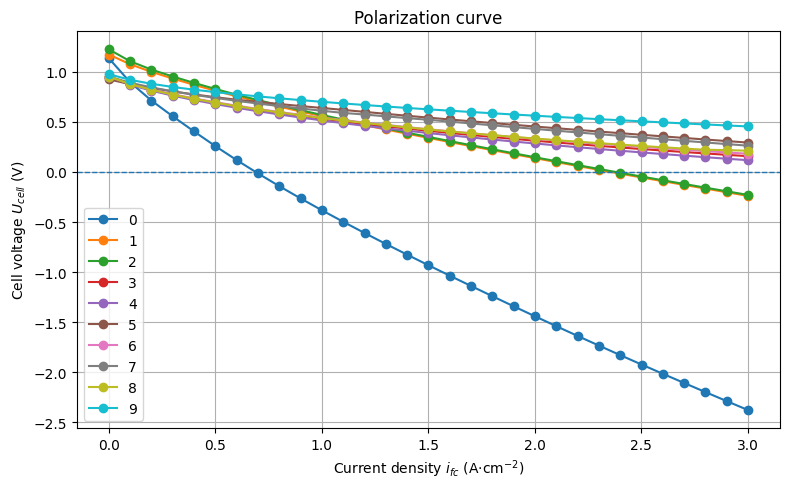

In [6]:
print("---------------------------------------------------------------------------------------------")
print("Curves where voltage starts between 0 and 1.23V and are (approx.) monotonically decreasing")
print("---------------------------------------------------------------------------------------------")
plot_polarization_curves(df_validity[df_validity["classification"] == "valid"].head(10),
                          label_mode="index")

---------------------------------------------------------------------------------------------
Invalid curves: voltage starts outside range or monotonicity is violated
---------------------------------------------------------------------------------------------


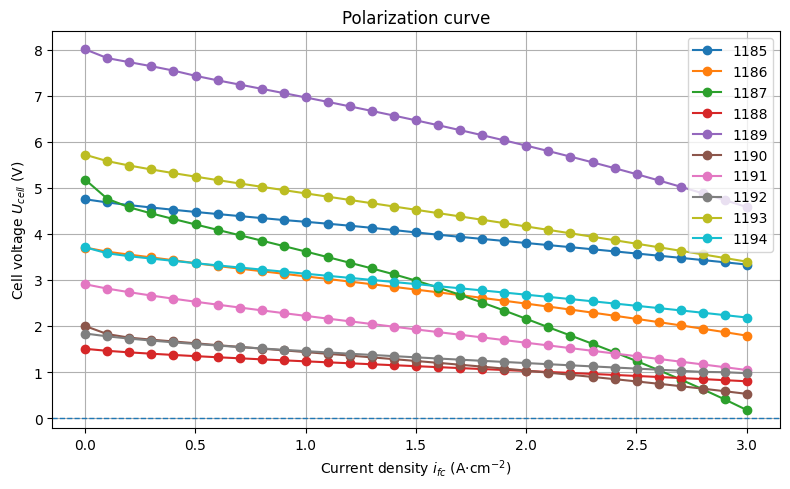

In [7]:
print("---------------------------------------------------------------------------------------------")
print("Invalid curves: voltage starts outside range or monotonicity is violated")
print("---------------------------------------------------------------------------------------------")

plot_polarization_curves(df_validity[df_validity["classification"] == "invalid"].head(10),
                          label_mode="index")

---------------------------------------------------------------------------------------------
Invalid curves: Non-monotonic behaviour (bump exceeded tolerance of 5mV)
---------------------------------------------------------------------------------------------


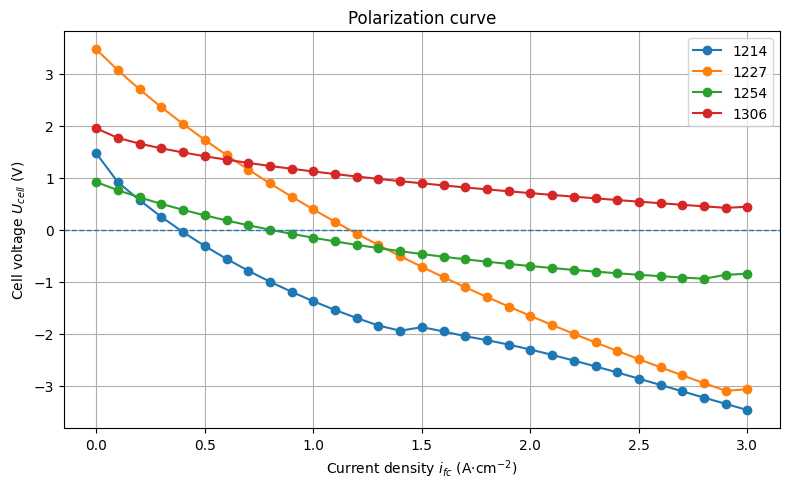

In [8]:
print("---------------------------------------------------------------------------------------------")
print("Invalid curves: Non-monotonic behaviour (bump exceeded tolerance of 5mV)")
print("---------------------------------------------------------------------------------------------")

plot_polarization_curves(df_validity[df_validity["approx_monotonic"] == False].head(4),
                          label_mode="index")

Now that the configurations have been classified, we can save this as the basis for our IRD pipeline.

In [9]:
# All 19 parameters
param_columns = spec.names

# Select only relevant columns
df_simplified_IRD = df_validity[["index"] + param_columns + ["classification"]].copy()

# Save the file
path_to_save = Path(processed_dir, "classified_configs_for_IRD_until_2025-06-16.csv")
df_simplified_IRD.to_csv(path_to_save, index = False)
print("Saved the", len(df_simplified_IRD), "classified configurations to", path_to_save)

Saved the 2370 classified configurations to ..\data\processed\classified_configs_for_IRD_until_2025-06-16.csv


## 4) Next step: learn a valid hyperbox with IRD in R

Next we will run an R script that applies IRD to the labeled data to find a hyperbox that keeps most valid curves while excluding invalid ones.  

### The IRD Approach and Our Pipeline

Interpretable Regional Descriptors (IRDs) are a way to define *hyperboxes*. That is, simple, axis-aligned ranges in the input space where the model's predictions (here, simulations) behave consistently.
Here, we use IRDs to find ***regions where AlphaPEM simulations are likely valid***.

Our pipeline looks like this:

**1. Labeled configurations:**
We start with N configurations and label them as valid or invalid by applying the `validate_polarization_curves()` function to their simulated outputs.
The dataset is roughly balanced between valid and invalid cases.

**2. Train a classifier:**
We fit a Random Forest to predict whether a given configuration will be valid.
This step is only an intermediate tool to help IRD find the most promising valid regions.

**3. Find a valid region:**
We apply the PRIM (Patient Rule Induction Method) algorithm to the labeled data, “peeling and pasting” the input space until we find the largest hyperbox around a reference valid configuration with ≥90% validity rate.

**4. Valid hyperbox:**
The resulting hyperbox is a set of simple bounds on the 19 input parameters.
Configurations inside this box are much more likely to yield valid polarization curves, allowing us to focus simulations there and avoid wasting resources on invalid points.

> Note: The repository with an R package for the IRD framework can be found [here](https://github.com/slds-lmu/supplementary_2023_ird).

### Run IRD from R to find the valid hyperbox

Now that we have labeled our configurations as valid or invalid, we can use the IRD package to find a simple, axis-aligned hyperbox where the model is likely to produce valid curves.

For that, we have created an R script (`run_ird.R`) that takes our labeled data and finds a *valid hyperbox* using one or more IRD methods. We need to pass it:

- The classified configurations CSV we just created.
- A reference configuration (`IRD_reference_config_19.yaml`) that sits inside a known valid region. We here use the example configuration coming from table 3.2 of Gass thesis.
- The desired probability range for the positive class (here: 80% to 100%)
- The IRD methods to use (for example, PRIM or MaxBox)
- The features that should be treated as categorical (here, `e`)

This script 
1. Trains a Random Forest to predict validity
2. Runs the selected IRD methods to find a valid hyperbox.
3. Post-processes the box to tighten bounds while preserving validity rate
4. Saves the following outputs to `results/model_validity`:
   - **`IRD_bounds_<method>_<run_name>.yaml`**: the final hyperbox bounds for that method
   - **`IRD_report_<method>_<run_name>.yaml`**: a table comparing original parameter ranges vs. IRD-restricted ranges
   - **`RF_<run_name>.txt`**: classification performance metrics of the Random Forest

First, let's define the arguments for the `run_IRD.R` script.

In [10]:
# Main directory
repo_root = parent.resolve()

# Find Rscript binary
rscript_bin = shutil.which("Rscript")
if rscript_bin is None:
    raise RuntimeError("Rscript not found in PATH. Please install R and ensure Rscript is available.")
print("Location of the Rscript executable:", rscript_bin)

# Paths relative to parent folder!
r_script = Path("R_scripts/scripts/run_IRD.R")
data_path = Path("data/processed/classified_configs_for_IRD_until_2025-06-16.csv")
xinterest_path = Path("configs/IRD_reference_config_19.yaml")

# Directory to save the results
outdir = "results/model_validity"
Path(outdir).mkdir(parents=True, exist_ok=True)  # Ensure output dir exists

# Directory of the irdpackage
ird_dir = "external/supplementary_2023_ird/irdpackage"

# Create a run name (included in filename)
run_name = f"demo_run_{datetime.datetime.now().strftime('%Y%m%d')}"

Location of the Rscript executable: C:\Users\User\anaconda3\envs\env_PEM\Scripts\Rscript.EXE


You can pass these when you call the script:

| Parameter                 | What it does                                | Default                                      |
| ------------------------- | ------------------------------------------- | -------------------------------------------- |
| `--data`                  | Path to CSV with features and target        | *(none)*                                     |
| `--target`                | Name of the target column                   | `classification`                             |
| `--positive`              | Which label is considered "positive"       | `valid`                                      |
| `--xinterest`             | JSON or YAML with a reference configuration | `configs/IRD_reference_config_19.yaml`                         |
| `--range`                 | Desired probability range (`low,high`)      | `0.8,1.0`                                    |
| `--outdir`                | Where to save results                       | `results/model_validity`                     |
| `--methods`               | IRD methods to run (comma-sep)              | `PRIM,MaxBox`                                |
| `--run_name`              | Tag for the run's output folder             | (none)                                   |
| `--categorical_overrides` | Features to treat as categorical            | `e`                                          |
| `--seed`                  | Random seed                                 | `42`                                         |
| `--ird_pkg_dir`           | Path to local `irdpackage` folder           | `external/supplementary_2023_ird/irdpackage` |


"

> Note: *`rscript_bin` should point to your Rscript executable and all paths should be absolute or set with `cwd` so R can find your files*

In [ ]:
# Command
cmd = [
    rscript_bin, str(r_script),
    "--data", str(data_path),
    "--target", "classification",
    "--positive", "valid",
    "--xinterest", str(xinterest_path),
    "--range", "0.8, 1.0",   # probability of finding a valid config
    "--methods", "PRIM, MaxBox",     # can be PRIM or MaxBox
    "--outdir", str(outdir),
    "--categorical_overrides", "e",
    "--run_name", run_name,
    "--ird_pkg_dir", str(ird_dir)
]

Now, we execute the code

In [ ]:
# Run
result = subprocess.run(cmd, capture_output=True, text=True, cwd = parent.resolve())

# Show outputs
print("=== STDOUT ===")
print(result.stdout)
print("=== STDERR ===")
print(result.stderr)

After running the script, we can load the generated YAML directly in Python to inspect the final bounds:

In [ ]:
bounds_file = Path("../results/model_validity/IRD_bounds_PRIM_demo_run_20250811_220320.yaml")
with open(bounds_file, "r") as f:
    prim_bounds = yaml.safe_load(f)

prim_bounds

{'parameters': [{'name': 'Tfc',
   'type': 'continuous',
   'low': 337.68,
   'high': 356.588,
   'fixed': False},
  {'name': 'Pa_des',
   'type': 'continuous',
   'low': 138534.0,
   'high': 295140.0,
   'fixed': False},
  {'name': 'Pc_des',
   'type': 'continuous',
   'low': 119413.0,
   'high': 269389.0,
   'fixed': False},
  {'name': 'Sa', 'type': 'continuous', 'low': 1.3, 'high': 1.3, 'fixed': True},
  {'name': 'Sc',
   'type': 'continuous',
   'low': 1.13201,
   'high': 2.98167,
   'fixed': False},
  {'name': 'Phi_a_des',
   'type': 'continuous',
   'low': 0.5,
   'high': 0.5,
   'fixed': True},
  {'name': 'Phi_c_des',
   'type': 'continuous',
   'low': 0.269186,
   'high': 0.669739,
   'fixed': False},
  {'name': 'epsilon_gdl',
   'type': 'continuous',
   'low': 0.604737,
   'high': 0.76796,
   'fixed': False},
  {'name': 'tau',
   'type': 'continuous',
   'low': 1.0019,
   'high': 3.67356,
   'fixed': False},
  {'name': 'epsilon_mc',
   'type': 'continuous',
   'low': 0.159872,

We can now use these suggested bounds to run our AlphaPEM simulations and be confident that most of the configurations will lead to valid polarization curves. 

Just keep in mind that both the number of samples used for the algorithm (here, only 2000) and the chosen validity criteria can influence the resulting hyperbox.